Fig 17.9 - Dishonest Casino (Loaded Dice Inference)
==============================================

In [12]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as pl
import seaborn as sns
sns.set_style('white')

First we need the data: we are going to generate 3000 dice rolls of a dice which has two states: $z = 1$, the dice is honest and each face has $1/6$ probability. The second state is $z = 2$, where the dice is loaded and the probability of landing on a 6 is $1/2$ and landing on any other face is $1/10$. The probability of transitioning from 1 to 2 is 0.05 and from 2 to 1 is 0.10. I.e., once switched the dice mostly stays in its current state.

In keeping with Murphy's notation, we are going to write the probabilities as follows: $\psi(j) = p(x_t | z_t = j)$ is the probability of having a dice roll $x_t$ at time $t$ given that it's state is $j$. As per described above, we have:

$$\psi(1) = (1/6, 1/6, 1/6, 1/6, 1/6, 1/6)$$
$$\psi(2) = (1/10, 1/10, 1/10, 1/10, 1/10, 1/2)$$

Likewise, we're going to call $\Phi(i, j)$ (instead of $\Psi$ as in the book, it's confusing!) the probability of transition from $z_{t-1} = i$ to $z_t = j$.

$$\Phi =
\begin{pmatrix}
  0.95 & 0.05 \\
  0.1 & 0.9
 \end{pmatrix}$$
 
Finally, we're going to assume the dice has equal probability of starting at either state, i.e.:

$$\pi = (0.5, 0.5)$$

Let us now generate the data!

In [14]:
psi = np.array([[1/6, 1/6, 1/6, 1/6, 1/6, 1/6],
                [1/10, 1/10, 1/10, 1/10, 1/10, 1/2]])
Phi = np.array([[0.95, 0.05],
                [0.1, 0.9]])
pi = np.array([0.5, 0.5])

def generate_data(n_samples=3000):
    z_0 = np.random.choice(range(2), p=pi)
    x_0 = np.random.choice(range(6), p=psi[z_0])
    z = [z_0]
    x = [x_0]
    for t in range(1, n_samples):
        z.append(np.random.choice(range(2), p=Phi[z[t-1]]))
        x.append(np.random.choice(range(6), p=psi[z[t]]))
    return np.array(z), np.array(x)

We generate the data and run some quick plots to show that it looks consistent:

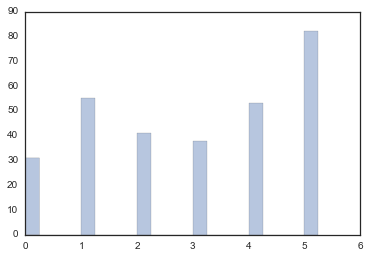

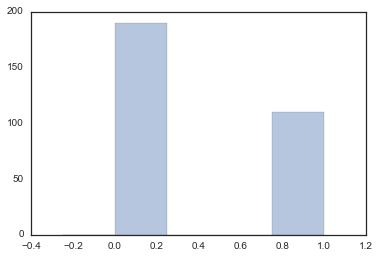

In [57]:
z, x = generate_data(300)

fig, ax = pl.subplots()
sns.distplot(x, bins=np.arange(0, 5.5, 0.25), kde=False);
fig, ax = pl.subplots()
sns.distplot(z, bins=np.arange(-0.25, 1.1, 0.25), kde=False)

We now implement the forward pass algorithm for filtering prediction and plot the inferred probability of the dice being loaded, with actual loaded regions shaded in grey.

In [144]:
def forward_pass(x, z):
    assert(len(x) == len(z))
    alpha_0 = Phi.T.dot(pi)
    alpha_0 /= np.sum(alpha_0)
    alpha = [alpha_0]
    for t in range(1, len(z)):
        alpha_t = psi[:, x[t]] * Phi.T.dot(alpha[t-1])
        alpha_t /= np.sum(alpha_t)
        alpha.append(alpha_t)
    return np.array(alpha)

def plot_inference(x, z, prob_vector, inference_label=None):
    fig, ax = pl.subplots(figsize=(16,9))
    font_size = 24
    ax.plot(prob_vector, '-')
    ax.fill_between(np.arange(len(x)), 0, 1, where=(z==1), color='grey', alpha=0.3)
    # ax.axhline(y=0.5, color='k', linestyle='--', alpha=0.1)
    ax.set_xlabel(r'$t$', fontsize=font_size)
    ax.set_ylabel(inference_label, fontsize=font_size)

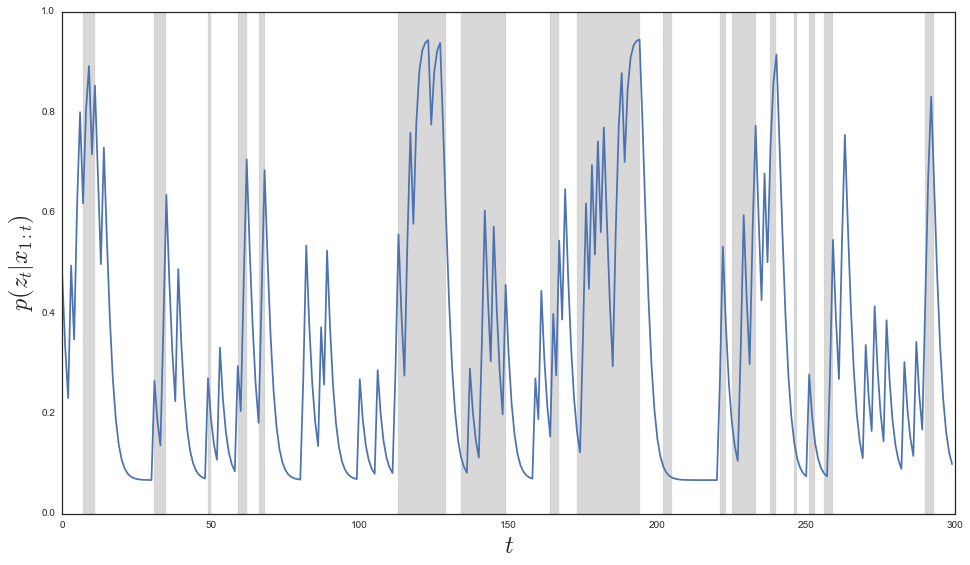

In [145]:
alpha = forward_pass(x, z)
plot_inference(x, z, alpha[:, 1], inference_label=r'$p(z_t | x_{1:t})$')

To do the smoothed prediction, where we predict each point by observing the whole history, not just up until that point, we also must implement the backward algorithm and combine the two.

In [134]:
def backward_pass(x, z):
    T = len(z)
    values_of_z = len(np.unique(z))
    beta = np.zeros((T, values_of_z))
    beta[-1] = np.ones(values_of_z)
    for i in range(1, T):
        t = T - 1 - i # for clarity (better than doing range(T-2, -1, -1))
        beta[t] = Phi.dot(psi[:, x[t+1]] * beta[t+1])
        # we shouldn't actually normalize, but we do so to avoid underflow
        beta[t] /= np.sum(beta[t])
    return beta

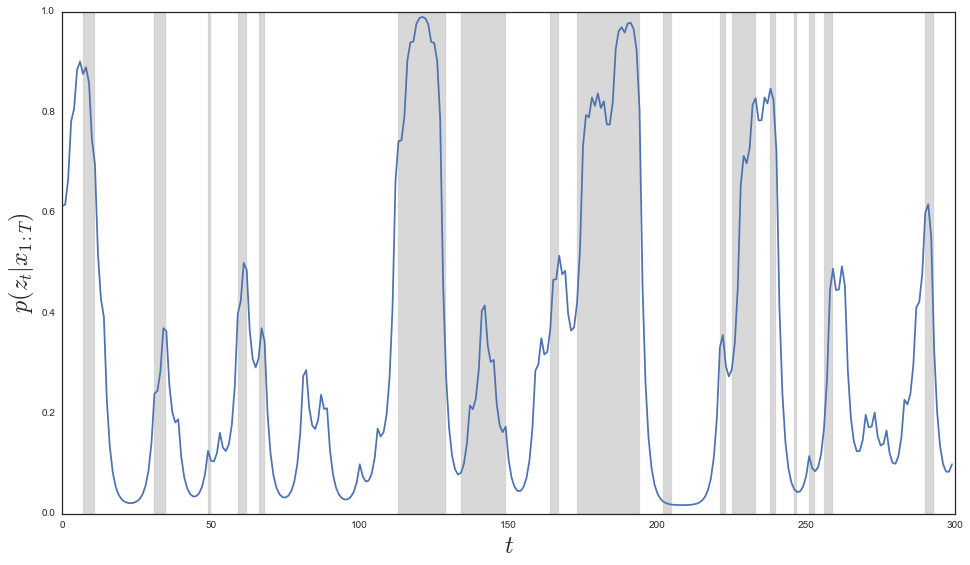

In [146]:
beta = backward_pass(x, z)
gamma = alpha * beta / np.sum(alpha * beta, axis=1)[:, None]
plot_inference(x, z, gamma[:, 1], inference_label=r'$p(z_t | x_{1:T})$')